# 국도교통빅데이터 정책 분석

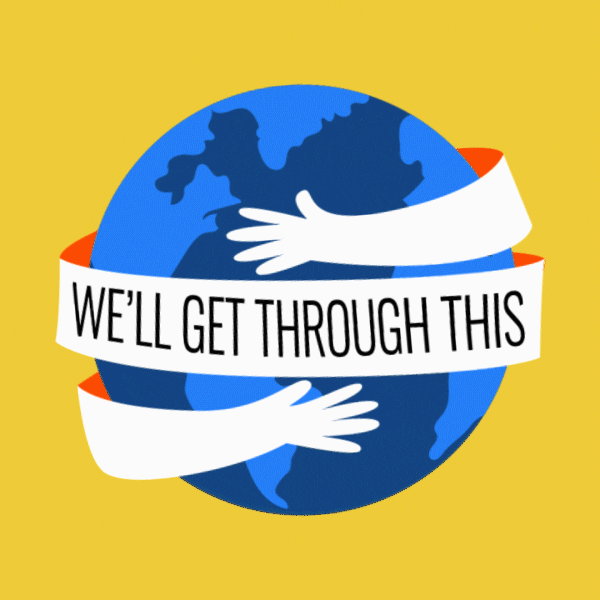
## 목표 

정책 데이터에 대한 EDA를 진행하여 정책의 흐름을 살펴보고 유의미한 결론을 내린다. 


## 정책

종류
* Alert 
  * 안전을 위해서 Alert Level에 따라서 인구 이동량 상승에 제한을 둘 필요가 있어 보인다. 
* Immigration 
  * 특정 나라에 대한 이동 제한은 국내의 이동량과의 관계 파악을 통해 이동량을 확인할 수 있다. 
  * 해외여행의 경우, 국내 여행으로 대체될 수 있음. ex) 제주도
* Health
  * 마스크 관련 정책으로 마스크 유통량이 증가할 경우, 사용량이 증가할 수 있다. 이동량이 많을지라도 감염률이 낮아질 수 있음
* Social
  * 사회적 거리두기 캠페인은 시민의식을 높여 이동량을 낮추게 된다. 
* Education
  * 학교의 오프라인 수업 여부에 따라서 감염량이 달라짐. 
* Technology
  * 마스크 공급에 도움을 준다. 
  * 마스크 착용을 높이는데 기여
* Administrative
  * 노래방, 유흥주점의 영업 금지는 코로나 유행에 영향을 미칠 수 있다.  
* Transformation
  * Mask 미착용자의 버스 제한이 버스 이용에 영향을 미칠 수 있음

## 결론

시기별로 유행하는 정책의 종류가 다르다. 

교통 데이터와 정책의 종류의 관계를 살펴볼 필요가 있다. 

## 분석

1. 시간별 정책의 종류
2. 정책의 비율
3. 정책 자연어에 대한 NLP
4. 정책 데이터에 대한 감성 분석 
 * 감정이랑 전혀 다른 방향으로 나타나기도 함
 * ex) Weak, Strong은 정책에서 각각 긍정과 부정이나 감정분석에서는 정반대로 작용


In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly

In [108]:
policy_df = pd.read_csv("/content/drive/My Drive/Data/COVID_19(수정)/Policy.csv")

In [199]:
def func(x):
    if x=='nan':
        return '0721'
    else:
        return x[5:7]+x[8:10]

policy_df['start_date'] = policy_df['start_date'].apply(lambda x: func(str(x)))
policy_df['end_date'] = policy_df['end_date'].apply(lambda x: func(str(x)))

_ = policy_df.sort_values(by='start_date')

Text(0.5, 1.0, 'Policy kinds by time')

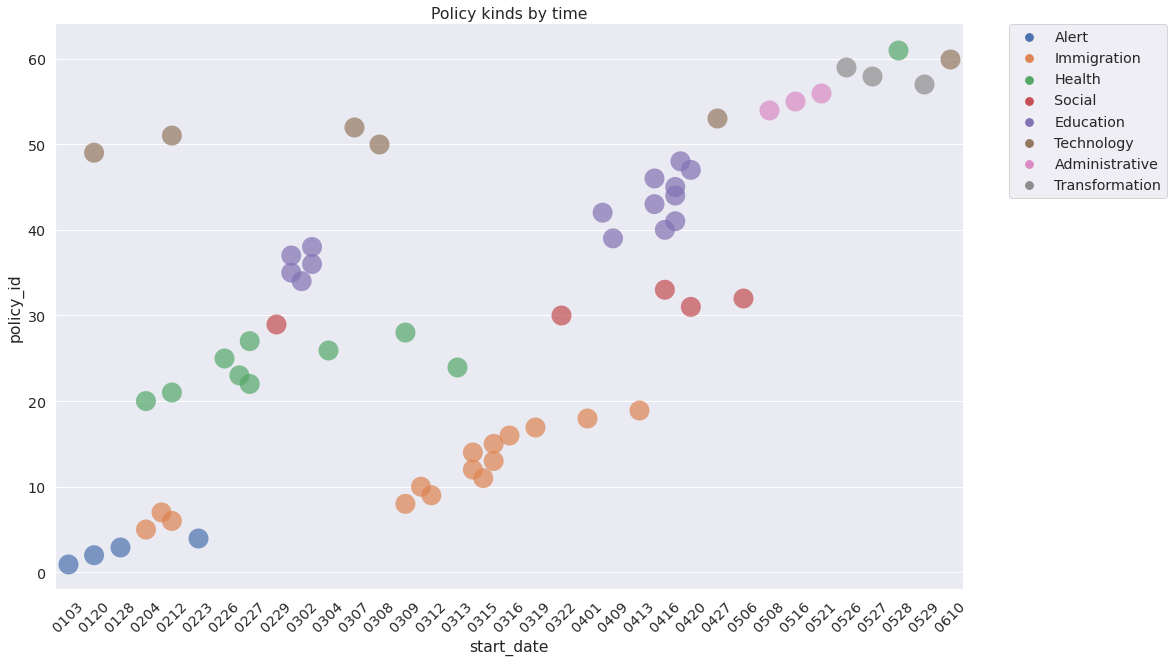

In [110]:
sns.set(font_scale=1.3)

g = sns.catplot('start_date', 
                'policy_id',
                hue='type',
                data=policy_df,
                kind='swarm',
                s = 20, alpha=0.7)
g.fig.set_size_inches(25,10)
g.set_xticklabels(rotation=45, fontweight='light')
g._legend.remove()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Policy kinds by time")

* Education(보라색)은 특정 시기에 몰려있습니다. 
* Immigration은 3월부터 4월까지 지속적으로 나타났습니다. 
* 최근에는 Administravie, Transformation 에 대한 정책이 진행되었습니다. 
* 9월달 개학과 관련되서 교육정책이 비슷한 분포로 나올지 궁금하네요.
* 제 예상으로는 사회적으로 이슈가 되는 것들 위주로 정책을 만드는 것 같습니다. 

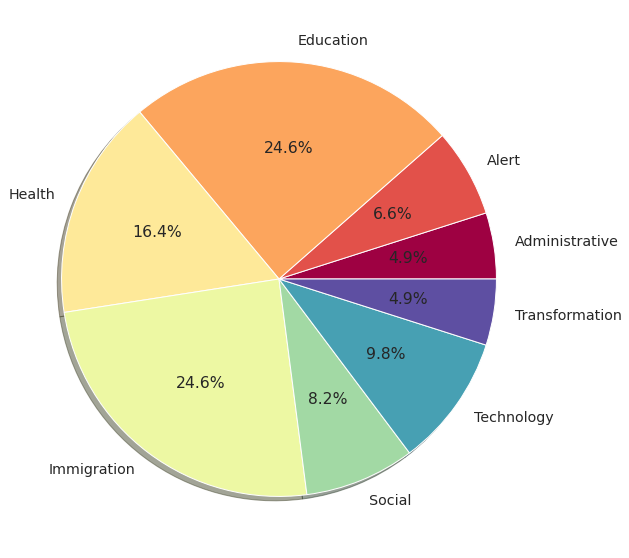

In [139]:
import numpy as np

temp = policy_df.groupby(['type']).count()[['start_date']].reset_index()
temp.columns = ['type', 'count']
size = list(temp['count'])

source_labels = temp['type']
source_counts = temp['count']

# Make square figures and axes
plt.figure(1, figsize=(20,10))

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
source_pie = plt.pie(source_counts, labels=source_labels, autopct='%1.1f%%', shadow=True, colors=colors)


plt.show()

* 교육, 건강, 이민과 관련된 정책이 가장 큰 비중을 차지합니다. 
* 종류별로 정책의 비율이 비슷한 걸 확인할 수 있습니다. 
* 이미 나와있는 정책에 관련된 정책이 추가적으로 나오는 것 같습니다. (예상)

## Policy Detail NLP

Text(0.5, 0, 'Word (gov_policy + detail)')

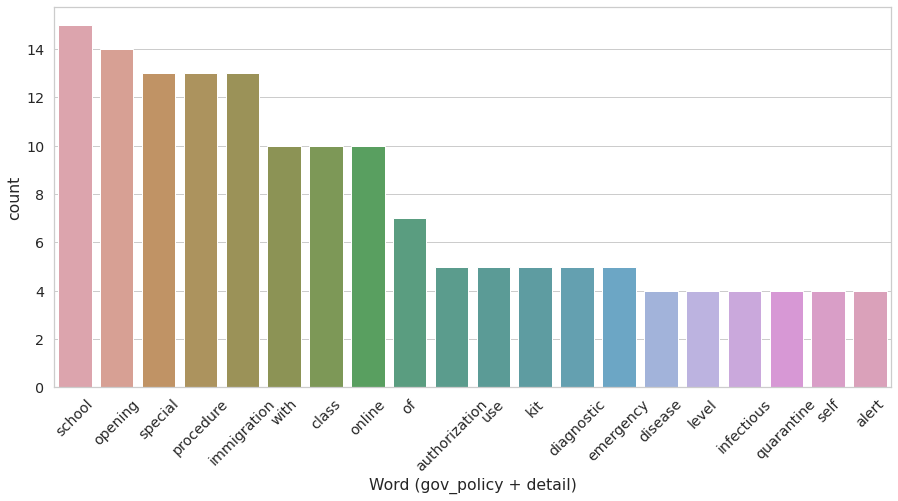

In [198]:
from sklearn.feature_extraction.text import CountVectorizer
_ = sns.color_palette("hls", 8)

policy_df['gov_policy'].fillna("", inplace=True)
policy_df['detail'].fillna("", inplace=True)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(policy_df['gov_policy'], 20)

df1 = pd.DataFrame(common_words, columns = ['gov_policy' , 'count'])
df1 = df1.groupby('gov_policy').sum()['count'].sort_values(ascending=False).reset_index()
df1.columns = ['word', 'count']

common_words = get_top_n_words(policy_df['detail'], 20)

df2 = pd.DataFrame(common_words, columns = ['detail' , 'count'])
df2 = df2.groupby('detail').sum()['count'].sort_values(ascending=False).reset_index()
df2.columns = ['word', 'count']

df1.merge(df2)


plt.figure(figsize=(15,7))
ax = sns.barplot('word', y="count", data=df1,
                  saturation=.5)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Word (gov_policy + detail)")

* 교육과 관련된 단어가 제일 많이 쓰였고, 이민이 두번째로 많이 쓰였습니다. 

##  sentiment polarity score (Useless)

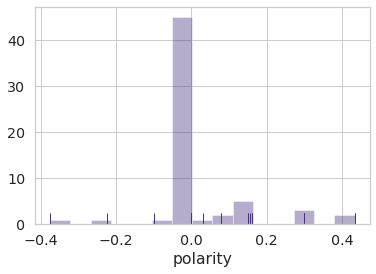

In [188]:
from textblob import TextBlob

sns.set_palette("viridis")
policy_df['polarity'] = policy_df['detail'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.distplot(policy_df['polarity'], kde=False, rug=True, bins=15)

* 단어의 대부분은 Polarity가 없는 걸 확인할 수 있습니다. 
* 또한 Polarity가 있을지라도 감정단어의 의미와 COVID에서 사용되는 단어의 의미가 다릅니다. (Domain Specific 하지 않음)

In [189]:
policy_df[policy_df['polarity']< -0.2]

,policy_id,country,type,gov_policy,detail,start_date,end_date,polarity
30,31,Korea,Social,Social Distancing Campaign,Weak,0420,0505,-0.37500
54,55,Korea,Administrative,local government Administrative orders,Gathering limited administrative orders for nu...,0516,0721,-0.22381


In [190]:
policy_df[policy_df['polarity']> 0.2]

,policy_id,country,type,gov_policy,detail,start_date,end_date,polarity
28,29,Korea,Social,Social Distancing Campaign,Strong,0229,0321,0.433333
29,30,Korea,Social,Social Distancing Campaign,Strong,0322,0419,0.433333
37,38,Korea,Education,School Opening Delay,Elementary School,0302,0406,0.300000
44,45,Korea,Education,School Opening with Online Class,Elementary School (5th ~ 6th grade),0416,0608,0.300000
45,46,Korea,Education,School Opening with Online Class,Elementary School (4th grade),0416,0603,0.300000


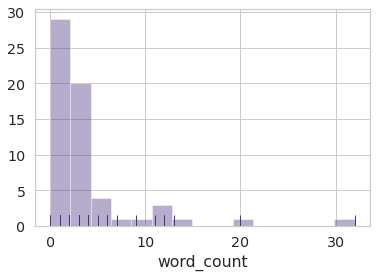

In [193]:
policy_df['word_count'] = policy_df['detail'].apply(lambda x: len(str(x).split()))
sns.distplot(policy_df['word_count'], kde=False, rug=True, bins=15)

# Appendix

Type 별로 Policy 내용을 모아두었습니다. 

관심있으신 정책 종류를 보시면 좋을 것 같습니다 :) 

In [15]:
policy_df[policy_df['type']=="Alert"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN


In [16]:
policy_df[policy_df['type']=="Immigration"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN
5,6,Korea,Immigration,Special Immigration Procedure,from Hong Kong,2020-02-12,NaN
6,7,Korea,Immigration,Special Immigration Procedure,from Macau,2020-02-12,NaN
7,8,Korea,Immigration,Special Immigration Procedure,from Japan,2020-03-09,NaN
8,9,Korea,Immigration,Special Immigration Procedure,from Italy,2020-03-12,NaN
9,10,Korea,Immigration,Special Immigration Procedure,from Iran,2020-03-12,NaN
10,11,Korea,Immigration,Special Immigration Procedure,from France,2020-03-15,NaN
11,12,Korea,Immigration,Special Immigration Procedure,from Germany,2020-03-15,NaN
12,13,Korea,Immigration,Special Immigration Procedure,from Spain,2020-03-15,NaN
13,14,Korea,Immigration,Special Immigration Procedure,from U.K.,2020-03-15,NaN


In [21]:
policy_df[policy_df['type']=="Health"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
19,20,Korea,Health,Emergency Use Authorization of Diagnostic Kit,1st EUA,2020-02-04,NaN
20,21,Korea,Health,Emergency Use Authorization of Diagnostic Kit,2nd EUA,2020-02-12,NaN
21,22,Korea,Health,Emergency Use Authorization of Diagnostic Kit,3rd EUA,2020-02-27,NaN
22,23,Korea,Health,Emergency Use Authorization of Diagnostic Kit,4th EUA,2020-02-27,NaN
23,24,Korea,Health,Emergency Use Authorization of Diagnostic Kit,5th EUA,2020-03-13,NaN
24,25,Korea,Health,Drive-Through Screening Center,by Local Government,2020-02-26,NaN
25,26,Korea,Health,Drive-Through Screening Center,Standard Operating Procedures,2020-03-04,NaN
26,27,Korea,Health,Mask Distribution,Public-Sale,2020-02-27,NaN
27,28,Korea,Health,Mask Distribution,5-day Rotation System,2020-03-09,NaN
60,61,Korea,Health,Extends Tightened Quarantine Measures,Gov't Extends Tightened Quarantine Measures in...,2020-05-28,2020-06-14


In [17]:
policy_df[policy_df['type']=="Social"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
28,29,Korea,Social,Social Distancing Campaign,Strong,2020-02-29,2020-03-21
29,30,Korea,Social,Social Distancing Campaign,Strong,2020-03-22,2020-04-19
30,31,Korea,Social,Social Distancing Campaign,Weak,2020-04-20,2020-05-05
31,32,Korea,Social,Social Distancing Campaign,Weak(1st),2020-05-06,NaN
32,33,Korea,Social,Thanks to Challenge korea,Relay Cheer Campaign in SNS,2020-04-16,NaN


In [14]:
policy_df[policy_df['type']=="Education"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
33,34,Korea,Education,School Closure,Daycare Center for Children,2020-03-02,NaN
34,35,Korea,Education,School Opening Delay,Kindergarten,2020-03-02,2020-04-06
35,36,Korea,Education,School Opening Delay,High School,2020-03-02,2020-04-06
36,37,Korea,Education,School Opening Delay,Middle School,2020-03-02,2020-04-06
37,38,Korea,Education,School Opening Delay,Elementary School,2020-03-02,2020-04-06
38,39,Korea,Education,School Opening with Online Class,High School (3rd grade),2020-04-09,2020-05-20
39,40,Korea,Education,School Opening with Online Class,High School (2nd grade),2020-04-16,2020-05-27
40,41,Korea,Education,School Opening with Online Class,High School (1st grade),2020-04-16,2020-06-03
41,42,Korea,Education,School Opening with Online Class,Middle School (3rd grade),2020-04-09,2020-05-27
42,43,Korea,Education,School Opening with Online Class,Middle School (2nd grade),2020-04-16,2020-06-03


In [18]:
policy_df[policy_df['type']=="Technology"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
48,49,Korea,Technology,Open Data,Patients Information,2020-01-20,NaN
49,50,Korea,Technology,Open API,Public Mask Sales Information,2020-03-08,NaN
50,51,Korea,Technology,Self-Diagnosis App,NaN,2020-02-12,NaN
51,52,Korea,Technology,Self-Quarantine Safety Protection App,NaN,2020-03-07,NaN
52,53,Korea,Technology,Electronic Wristbands,on people who violate self-quarantine measures,2020-04-27,NaN
59,60,Korea,Technology,KI-Pass: Korea Internet - Pass,new quick response (QR) code system this week ...,2020-06-10,NaN


In [19]:
policy_df[policy_df['type']=="Administrative"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
53,54,Korea,Administrative,Close bars and clubs,administrative order to close bars and clubs,2020-05-08,2020-06-07
54,55,Korea,Administrative,local government Administrative orders,Gathering limited administrative orders for nu...,2020-05-16,NaN
55,56,Korea,Administrative,Close karaoke,Ban on gathering for 2 weeks for all karaoke a...,2020-05-21,2020-06-03


In [20]:
policy_df[policy_df['type']=="Transformation"]

,policy_id,country,type,gov_policy,detail,start_date,end_date
56,57,Korea,Transformation,Logistics center,On-site inspection of major logistics faciliti...,2020-05-29,2020-06-11
57,58,Korea,Transformation,Wearing of masks,"Mandatory wearing of passenger mask domestic, ...",2020-05-27,NaN
58,59,Korea,Transformation,Wearing of masks,Drivers such as buses and taxis can refuse to ...,2020-05-26,NaN


EDA 진행해서 올리는 것은 처음인데 무엇보다 어떤 내용을 분석해야 하는지 고민이 많았습니다. 

코로나가 빨리 종식되지 않을 것 같지만... 언능 끝났으면 좋겠습니다.  

내용에 대해서 비평, 코멘트, 칭찬등은 모두 환영입니다. 

Thank you for reading my article ! 🙋‍♂️🙋‍♂️ :) 

